In [1]:
import os
import cv2
import matplotlib.pyplot as plt

In [2]:
data_ = ".\\..\\data"
images_folder = os.path.join(data_, "images")
labels_folder = os.path.join(data_, "labels")


In [19]:
def plot_img(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

In [9]:
processed_data_path = os.path.join(data_, "processed_data")

if not os.path.exists(processed_data_path):
    os.makedirs(processed_data_path)

In [17]:
for image in os.listdir(images_folder):
    label_name = image[:-4] + ".txt"

    image = os.path.join(images_folder, image)
    label = os.path.join(labels_folder, label)

    img = cv2.imread(image)
    
    break

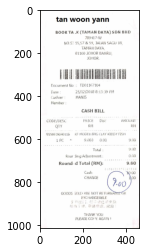

In [20]:
plot_img(img)

In [3]:
height = []
width = []

for image in os.listdir(images_folder):
    image = cv2.imread(os.path.join(images_folder, image))

    h, w, _ = image.shape

    height.append(h)
    width.append(w) 

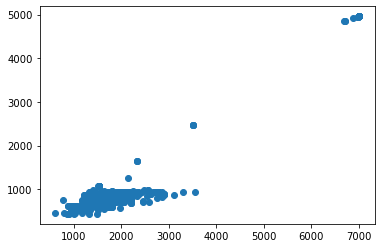

In [5]:
plt.scatter(height, width)

In [8]:
import numpy as np
